# How to compare two empirical distributions

date: 2022-05-05
tags: probability, python, scipy
description: A comparison of common methods to compare two probability distributions in Python
draft: false
<!--eofm-->

The world is full of distributions - people's height, incomes, exam results, average temperatures, heights of trees, sizes of microplastic particles in the environment. It stands to reason that there will be times when we need to compare these distributions to see how similar (or different) they are. For example, were summer temperatures similar this year to last year? Do two groups of people who buy different products make similar incomes? Do modelled size distributions of microplastics match what we expect from observations?

There are a whole host of statistical methods you can use to calculate this similarity, and the aim of this post is to show you how a few of the most common can be easily coded in Python. In doing so, we will start to explore some of the differences between the methods and why you might pick one over the other. What this article isn't is a rigorous mathematical guide to each of these tests - for that, I recommend the reader refers to some of the linked references through this post.

## The problem



Let's start with three arbitrary normal distributions to demonstrate this. We will use SciPy's [`stats.norm.rvs`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) method to generate these distributions by randomly sampling based on specified mean and variance values - basically, this lets us mimic "real" data that follows the specified distributions.

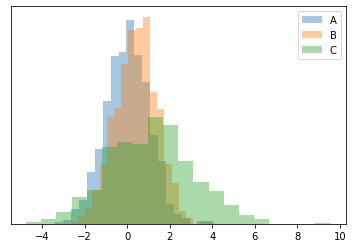

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

# Mean and variance of the distributions and sampling size
a_mean, a_var = 0.0, 1.0
b_mean, b_var = 0.42, 1.0
c_mean, c_var = 1.2, 2
size = 1000

# Create the distributions
data_a = stats.norm.rvs(a_mean, a_var, size)
data_b = stats.norm.rvs(b_mean, b_var, size)
data_c = stats.norm.rvs(c_mean, c_var, size)

# Plot the distributions as histograms to see what they
# look like compared to each other
plt.hist(data_a, bins=20, density=True, alpha=0.4, label='A')
plt.hist(data_b, bins=20, density=True, alpha=0.4, label='B')
plt.hist(data_c, bins=20, density=True, alpha=0.4, label='C')
plt.legend()
plt.yticks([])
plt.show()

## Comparing the means

Perhaps it is stating the obvious, but if you expect all of the other [moments of your distributions](https://en.wikipedia.org/wiki/Moment_(mathematics)) (variance, skew and kurotis) to be similar, then comparing the means is a simple but effective way to see how different they are.

If we take $A$ as the reference distribution, to which we want to compare how similar $B$ and $C$ are, then we can simply calculate the difference between the means of $B$ or $C$ and $A$:

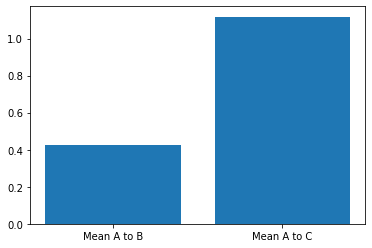

In [2]:
plt.bar(['Mean A to B', 'Mean A to C'],
        [data_b.mean() - data_a.mean(), data_c.mean() - data_a.mean()])
plt.show()

The rather obvious conclusion here is that $B$ is *more similar* to $A$ than $C$. But, you will have noticed that the variance (width) of $C$ is significantly different $A$ and $B$, and perhaps this naïve method is not so sensible for our distributions.

## Kolmogorov-Smirnov test

Apart from comparing means, calculating the [K-S distance](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) between distributions is perhaps the most common way of comparing distributions. The K-S distance is zero when distributions are identical, and 1 when they are very different. In other words, the bigger the K-S distance, the more different the distributions.

The concept behind the K-S distance is simple to understand: When plotted as *empirical* cumulative probability distributions, it represents the biggest difference in probability between the two distributions. Calculating the K-S distance in Python is made straightforward by SciPy, which provides a [`scipy.stats.kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) function that does the hard work: 


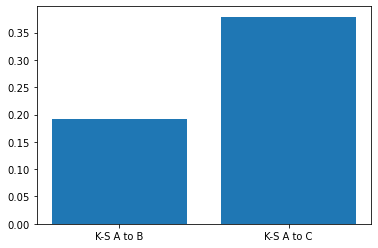

In [3]:
# Calculuate the K-S distance between A and B, and A and C
ks_a_b = stats.kstest(data_a, data_b)
ks_a_c = stats.kstest(data_a, data_c)

# Plot this to compare the distributions
plt.bar(['K-S A to B', 'K-S A to C'],
        [ks_a_b.statistic, ks_a_c.statistic])
plt.show()

{{< notice note >}}
Technically, we are performing a *two-sample* K-S test here, which is used to compare the underlying distributions of two independent samples. In contrast, the one-sample K-S test is used to compare the underlying distribution of a sample against a given distribution (such as the normal distribution). Internally, SciPy picks up that we have provided two independent samples and calls a separate [`scipy.stats.ks_2samp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) method. We could have called this method directly.
{{< /notice >}}

As we said, the K-S distance represents the maximum distance between the empirical cumulative distribution functions (ECDFs) of our data. As an aside, we can generate and plot these ECDFs to make it easy to visualise what the K-S test is doing in practice. Let's do this to compare A and C:

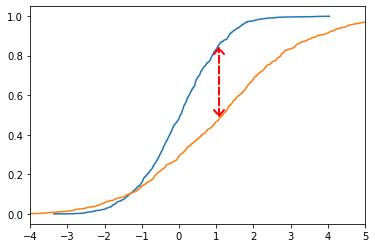

In [4]:
# We can plot ECDFs by sorting the data and plotting it on
# the x-axis against an equally spaced array from 0 to 1 on
# the y-axis, we can be generated by NumPy's linspace or
# arange functions
x_a = np.sort(data_a)
x_c = np.sort(data_c)
ecdf_a = np.linspace(0, 1, len(x_a), endpoint=False)
ecdf_c = np.linspace(0, 1, len(x_c), endpoint=False)

# Plot these ECDFs
plt.plot(x_a, ecdf_a)
plt.plot(x_c, ecdf_c)

# We need to figure out at which x value the biggest distance
# between the ECDFs is, in order to point this out on the graph.
# To do this, we first need to interpolate one of the ECDFs
ecdf_a_interp = np.interp(x_a, x_c, ecdf_a)
ix = np.argmax(np.abs(ecdf_a_interp - ecdf_c))

# Plot this as an arrow indicating the distance between the curves
plt.annotate('',
             xy=(x_a[ix], ecdf_a[ix]),
             xytext=(x_a[ix], ecdf_a[ix] - ks_a_c.statistic),
             arrowprops={'arrowstyle': '<->, head_width=0.5, head_length=0.6',
                         'linestyle': 'dashed', 'color': 'r', 'linewidth': 2})
plt.xlim([-4,5])
plt.show()

Though the K-S test is (arguably) a more justifiable method than simply comparing means, it is still a relatively crude way of comparing distributions. It only compares distributions at their maximum divergance and is therefore often seen as conservative.

## Anderson-Darling test

Another common test of similarity is the [Anderson-Darling test](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test). This takes into account the entire difference between ECDFs, rather than just the maximum, and therefore is often regarded as a better measure of similarity.

Again, we can use SciPy to calculate this statistic. We want to use the [`scipy.stats.anderson_ksamp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html) method, as opposed to the [`scipy.stats.anderson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html) method, as we have two samples to compare. The later is for comparing one empirical distribution against a continuous distribution such as the normal distribution.

C:\Users\sharrison\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: p-value floored: true value smaller than 0.001
  
C:\Users\sharrison\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: p-value floored: true value smaller than 0.001
  This is separate from the ipykernel package so we can avoid doing imports until


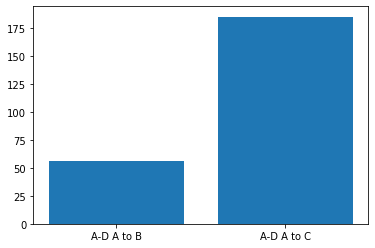

In [5]:
# We can use SciPy to calculate the Anderson-Darling test
ad_a_b = stats.anderson_ksamp([data_a, data_b])
ad_a_c = stats.anderson_ksamp([data_a, data_c])

# Plot this to compare the distributions
plt.bar(['A-D A to B', 'A-D A to C'],
        [ad_a_b.statistic, ad_a_c.statistic])
plt.show()

As you can see, compared to the previous tests, the difference between $A$ and $C$ is shown as more significant than the difference between $A$ and $B$. This makes sense: $C$ is a much broader distribution (has a larger variance) than $A$ and $B$, and because the Anderson statistic takes into account the whole distribution, it picks this up. Comparing means and the K-S test ignore the shape of the distribution.


## Wasserstein distance

The Wasserstein, or ["Earth Mover's Distance"](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) is intuitively easy to understand: Imagine your distributions are two different piles of the same volume of dirt. The Wasserstein distance is the minimum cost - defined as the amount of earth that needs to be moved multiplied by the distance it has to be moved - required to transform one pile into the other. In our case, another way of picturing it is as the area between the ECDFs of our data.

SciPy has a handy function [`scipy.stats.wasserstein_distance`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) that makes calculating the Wasserstein distance easy:

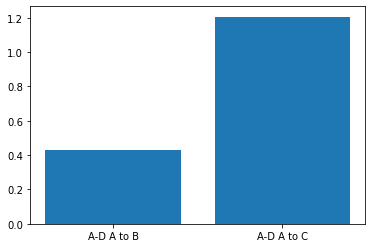

In [21]:
# Use SciPy to calculate the Wasserstein distance
wd_a_b = stats.wasserstein_distance(data_a, data_b)
wd_a_c = stats.wasserstein_distance(data_a, data_c)

# Plot this to compare the distributions
plt.bar(['A-D A to B', 'A-D A to C'],
        [wd_a_b, wd_a_c])
plt.show()

## Methods based on probability densities

The above methods only require the underlying sample data (`data_a` etc). There are host of methods that instead require the probability density function (PDF) of those data to be estimated. We can relatively easily achieve this using NumPy's `histogram` method (which is effectively what we were doing when we plotted the distributions as histograms above). Here we normalise the PDFs to sum to 1, but we don't strictly need to do this when passing them to SciPy, as this is usually taken care of internally. Still, it's a good practice to get into.

In [16]:
# The x space we want to interpolate from and to
x_interp = np.linspace(data_a.min(), data_c.max(), size)

# The PDFs from A, D and E
pdf_a, _ = np.histogram(data_a, bins=x_interp)
pdf_b, _ = np.histogram(data_b, bins=x_interp)
pdf_c, _ = np.histogram(data_c, bins=x_interp)

# We need to normalise these to make them real PDFs that sum to 1
pdf_a = pdf_a / pdf_a.sum()
pdf_b = pdf_b / pdf_b.sum()
pdf_c = pdf_c / pdf_c.sum()

## Jenson-Shannon divergence

The Jenson-Shannon (J-S) divergence is another popular method of calculating the distance between distributions. It is based on the famous Kullback-Leibler divergence, but is symmetric ($JS(p || q)$ is the same as ($JS(q || p)$ and always finite, whilst Kullback-Leibler is not. Similarly to other distances and divergences, it is 0 when the distributions are very similar. SciPy provides us another convenient method [`scipy.spatial.distance.jensenshannon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html) to make our lives easier:

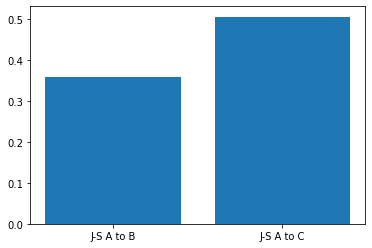

In [19]:
import scipy.spatial.distance

js_a_b = scipy.spatial.distance.jensenshannon(pdf_a, pdf_b)
js_a_c = scipy.spatial.distance.jensenshannon(pdf_a, pdf_c)

# Plot this to compare the distributions
plt.bar(['J-S A to B', 'J-S A to C'],
        [js_a_b, js_a_c])
plt.show()

## Hellinger distance

Our final example is the [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance) $H$, which is closely related to the [Bhattacharyya](https://en.wikipedia.org/wiki/Bhattacharyya_distance) coefficient $BC$ and distance $D_B$. In its continuous form, this approximates the area of the overlap between two distributions, effectively integrating this overlap. In its discrete form, $BC$ given by:

$$
BC(P,Q) = \Sigma_{i=1}^{n} \sqrt{P_i Q_i}
$$

where $P$ and $Q$ are our PDFs, both of length $n$ and over the same sample space. The Bhattacharyya distance is then defined as:

$$
D_B(P,Q) = -\ln(BC)
$$

The Hellinger distance is given by:

$$
H(P,Q) = \sqrt{1 - BC(P,Q)}
$$

$BC$ and $H$ is always between 0 and 1, whilst $D_B$ is greater than 0 but has no upper bound. In constrast to the other statistical distances we have looked at here, $BC$ is larger the more simliar the distributions are. This time, there is no SciPy method to rely on, but fortunately, as you can see from the above formulae, the calculation is rather straightforward:

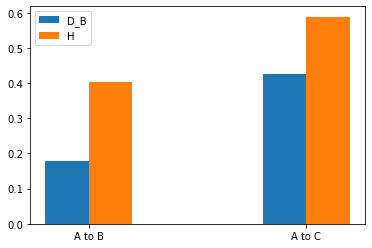

In [25]:
# Calculate BC between A,D and A,E
bc_a_b = np.sum(np.sqrt(np.multiply(pdf_a, pdf_b)))
bc_a_c = np.sum(np.sqrt(np.multiply(pdf_a, pdf_c)))

# Use these to calculate D_B
db_a_b = -np.log(bc_a_b)
db_a_c = -np.log(bc_a_c)

# And the Hellinger distance
h_a_b = np.sqrt(1 - bc_a_b)
h_a_c = np.sqrt(1 - bc_a_c)

# Plot D_B and H
x = np.arange(2)
width = 0.2
plt.bar(x - width / 2, [db_a_b, db_a_c], width, label='D_B')
plt.bar(x + width / 2, [h_a_b, h_a_c], width, label='H')
plt.legend()
plt.xticks(x, ['A to B', 'A to C'])
plt.show()

## What about *far apart* distributions?

You might have noticed that most of the above methods are some kind of measure of the overlap of distribution. But what if the distribution don't overlap - what if they are *far apart* and we want to test *how far apart* they are? Let's create two new distributions that are far away from $A$:

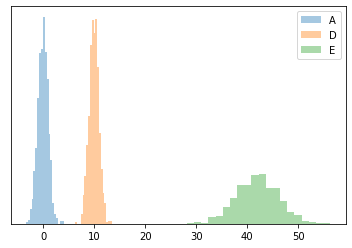

In [33]:
# Create the new distributions
data_d = stats.norm.rvs(10, 1, size)
data_e = stats.norm.rvs(42, 4.2, size)

# And their PDFs
x_interp = np.linspace(data_a.min(), data_e.max(), size)

# The PDFs for D and E
pdf_d, _ = np.histogram(data_d, bins=x_interp)
pdf_e, _ = np.histogram(data_e, bins=x_interp)

# Normalise these PDFs
pdf_d = pdf_d / pdf_d.sum()
pdf_e = pdf_e / pdf_e.sum()

# Plot them as histograms to see what they look like
# compared to each other
plt.hist(data_a, bins=20, density=True, alpha=0.4, label='A')
plt.hist(data_d, bins=20, density=True, alpha=0.4, label='D')
plt.hist(data_e, bins=20, density=True, alpha=0.4, label='E')
plt.legend()
plt.yticks([])
plt.show()

Now run all of our tests again and plot the statistics on a bar chart. For comparison purposes, we will normalise the statistics.

C:\Users\sharrison\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: p-value floored: true value smaller than 0.001
  
C:\Users\sharrison\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: p-value floored: true value smaller than 0.001
  import sys


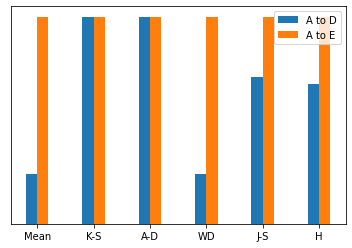

In [35]:
# Calculate the mean, K-S and A-D statistics
mean_a_d = data_d.mean() - data_a.mean()
mean_a_e = data_e.mean() - data_a.mean()
ks_a_d = stats.kstest(data_a, data_d)
ks_a_e = stats.kstest(data_a, data_e)
ad_a_d = stats.anderson_ksamp([data_a, data_d])
ad_a_e = stats.anderson_ksamp([data_a, data_e])
wd_a_d = stats.wasserstein_distance(data_a, data_d)
wd_a_e = stats.wasserstein_distance(data_a, data_e)
js_a_d = scipy.spatial.distance.jensenshannon(pdf_a, pdf_d)
js_a_e = scipy.spatial.distance.jensenshannon(pdf_a, pdf_e)
h_a_d = np.sqrt(1 - np.sum(np.sqrt(np.multiply(pdf_a, pdf_d))))
h_a_e = np.sqrt(1 - np.sum(np.sqrt(np.multiply(pdf_a, pdf_e))))

# Normalise the tests that aren't already between 0 and 1
mean_a_d = mean_a_d / max(mean_a_d, mean_a_e)
mean_a_e = mean_a_e / max(mean_a_d, mean_a_e)
ad_a_d_s = ad_a_d.statistic / max(ad_a_d.statistic, ad_a_e.statistic)
ad_a_e_s = ad_a_e.statistic / max(ad_a_e.statistic, ad_a_e.statistic)
wd_a_d = wd_a_d / max(wd_a_d, wd_a_e)
wd_a_e = wd_a_e / max(wd_a_d, wd_a_e)
js_a_d = js_a_d / max(js_a_d, js_a_e)
js_a_e = js_a_e / max(js_a_d, js_a_e)

# Plot the statistics
x = np.arange(6)
width = 0.2
plt.bar(x - width / 2, [mean_a_d, ks_a_d.statistic, ad_a_d_s, wd_a_d, js_a_d, h_a_d], width, label='A to D')
plt.bar(x + width / 2, [mean_a_e, ks_a_e.statistic, ad_a_e_s, wd_a_e, js_a_e, h_a_e], width, label='A to E')
plt.legend()
plt.xticks(x, ['Mean', 'K-S', 'A-D', 'WD', 'J-S', 'H'])
plt.yticks([])
plt.show()

As you can see, K-S and A-D tests reach their maximum value as soon as the distribution no longer overlap, and are therefore not useful for comparing far apart distributions. On the other hand, the mean, Wasserstein distance, J-S distance and Hellinger distance all do a good job of determining that $E$ is further from $A$ than $D$ is.

## What other tests are there?

Far to many to list here! But as a rough summary of the popular ones I haven't included:
- Simpler tests like the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error), [R-squared test](https://en.wikipedia.org/wiki/Coefficient_of_determination) and [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test), which are more often used for testing observations to a continuous distribution (such as modelled data).
- [L1 and L2 distances](https://machinelearningmastery.com/vector-norms-machine-learning), which are popular for data science and machine learning applications.
- Other *f*-divergence tests such as the [total variation distance](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures).
- And others - [check out this Wikipedia article](https://en.wikipedia.org/wiki/Statistical_distance).

## Summary

Here I have shown a small selection of the most commonly used statistical tests that you can use to compare empirical distributions. Which test you choose ultimately depends on your data and what hypothesis you are testing, but I hope this brief overview has at least highlighted a few options that you may wish to explore further.